## Peterson Barney Data
+ ###### Author: Dirk Van Compernolle   
+ ###### Modification History:  9/1/2024
+ ###### pyspch >=  0.8


##### Reference
G. Peterson and H. Barney, "Control methods used in a study of vowels," Journal of the Acoustical Society 
of America, vol. 24, pp. 175-184, 1952   .
##### Purpose
Especially Fig. 8 from this paper has become famous.
In this notebook we try to recreate this plot, but also allow for slightly different implementation of statistics and visualization.


<img src="./PetersonBarney_1952_fig8.jpg" alt="PB fig8"/>

##### Disclaimers  
+  The original speech data was not preserved, but the formant measurements were.  This data has been reused in a number of publications.
I cannot guarantee that the dataset that I got is 100% correct as I don't remember exactly how I got them; I believe indirectly via Tony Robinson  
+  The average formant values obtained in this paper slightly deviate from the ones published in the 1952 paper, though the differences are barely significant. This is likely due to a slightly different frequency warping, numerical (rounding) errors, ...      
+ This data is much cleaner and more consistent than the data later collected by Hillenbrand (1995).  So in a sense, this data looks too good to be true.

In [18]:
# uncomment the pip install command to install pyspch -- it is required!
#
#!pip install git+https://github.com/compi1234/pyspch.git
#
try:
    import pyspch
except ModuleNotFoundError:
    try:
        print(
        """
        To enable this notebook on platforms as Google Colab, 
        install the pyspch package and dependencies by running following code:

        !pip install git+https://github.com/compi1234/pyspch.git
        """
        )
    except ModuleNotFoundError:
        raise

In [3]:
# do all the imports and some generic settings
%matplotlib inline
import sys,os
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
import pandas as pd
import seaborn as sns
import librosa
from copy import copy,deepcopy

import pyspch.core as Spch
import pyspch.display as Spd
#
np.set_printoptions(precision=2)
pd.options.display.float_format = '     {:.0f}  '.format
mpl.rcParams['figure.figsize'] = [8.,8.]
mpl.rcParams['font.size'] = 10
# get default color and marker orders for pyspch.display
markers = Spd.markers

### Read the data 
The full dataset contains 2 repetitions of each vowel by each speaker (33 men, 28 women and 15 children).
You can select part of the data by setting the lists:
- gender: a list containing a selection of 'M','W','C'
- repetition: a list containing a selection of 1,2

Fig. 8 was constructed using genders=\['M', 'W', 'C'\] and repetition=\[2\]

Selecting all ADULT data is obtained by setting genders=\['M', 'W'\] and repetition=\[1, 2\]

In [4]:
file = 'https://homes.esat.kuleuven.be/~spchlab/data/PetersonBarney/peterson_barney_data.csv'    
genders = ['M','W','C']
repetition = [2]
vowels = ['IY','IH','EH','AE','AA','AO','UH','UW','AH','ER']
words = ["heed","hid","head","had","hod","hawed","hood","who'd","hud","heard"]
colors = ['blue', 'magenta', 'navy', 'cyan', 'green','limegreen','darkorange','red','brown', 'gold']
#
data_raw = pd.read_csv(file,sep=';')
data = data_raw.loc[:,["vowel","gender","F1","F2","F3"]]
data = data[data['gender'].isin(genders)]
data = data[(data.index%2+1).isin(repetition)]
# make sure that our categorical classes always appear in the same order for summarization/visualization
data['gender'] = pd.Categorical(data['gender'], categories = genders , ordered = True ) 
data['vowel'] = pd.Categorical(data['vowel'], categories = vowels, ordered = True) 
#
vowel2color = dict(zip(vowels,colors))
color2vowel = dict(zip(colors,vowels))
cmap = sns.color_palette(colors)
sns.set_palette(cmap)

### Frequency Transformation to be applied to F2 and F3
In the Peterson Barney paper F1 is shown on a linear scale and F2 on a warped frequency scale.
Details on the warping are not given in the paper.  Most likely an early version of the 'mel-scale'
was used.  Here we use the mel scale as implemented in HTK which is a reasonable match.
We apply the transformation both to F2 and F3 before computing averages or plotting.
The axis labels is in Hz for easy interpretation.
Below set SCALE to 'HTK' for this transformation; set it to 'LINEAR' for maintaining linear frequency.
In summary we found that for these experiments the differences are quite limited.

In [5]:
SCALE = 'HTK'
def f2m(f):
    if SCALE == 'HTK':
        return(librosa.hz_to_mel(f,htk=True))
    else: 
        return(f)
def m2f(m):
    if SCALE == 'HTK':
        return(librosa.mel_to_hz(m,htk=True))
    else:
        return(m)

# set up default yticks for the F2 axis
yticks = np.array([750,1000,1500,2000,2500,3000,3500])
yticks_l= f2m(yticks)
ytick_labels = ["750","1000","1500","2000","2500","3000","3500"]
ylim = [500,3900]
xlim = [100,1500]

In [6]:
# add the transformed data as extra columns to the DataFrame
data['F2t']=f2m(data['F2'])
data['F3t']=f2m(data['F3'])

### Compute average Formant Values
The computations are done gender independent and gender dependent
The 'F2t' and 'F3t' values contain the averages computed in the transform domain.
The 'F2' and 'F3' values are 'F2t' and 'F3t' reconverted to Hz

In [7]:
formants_gd = data.groupby(by=["vowel","gender"]).mean().unstack()
formants_all = data.groupby(by=["vowel"]).mean()
# add the example words to the table
formants_all.insert(0,"word",words)
formants_all.set_index(['word'],append=True,inplace=True)
formants_gd.insert(0,"word",words)
formants_gd.set_index(['word'],append=True,inplace=True)

# to view F2t reconverted to Hz
formants_all['F2'] = m2f(formants_all['F2t'])
formants_all['F3'] = m2f(formants_all['F3t'])
formants_gd['F2'] = m2f(formants_gd['F2t'])
formants_gd['F3'] = m2f(formants_gd['F3t'])

display(formants_all.loc[:,["F1","F2","F3"]].T)
display(formants_gd.loc[:,["F1","F2","F3"]].T)

vowel,IY,IH,EH,AE,AA,AO,UH,UW,AH,ER
word,heed,hid,head,had,hod,hawed,hood,who'd,hud,heard
F1,301,432,590,806,831,600,477,352,725,508
F2,2637,2292,2153,1947,1186,909,1143,943,1339,1537
F3,3220,2923,2857,2737,2704,2664,2591,2569,2687,1869


vowel              IY          IH          EH          AE          AA  \
word             heed         hid        head         had         hod   
   gender                                                               
F1 M            265         385         526         665         719     
   W            309         439         612         860         852     
   C            368         524         689        1014        1035     
F2 M           2295        1981        1837        1720        1085     
   W           2785        2472        2330        2046        1220     
   C           3203        2716        2602        2312        1358     
F3 M           2944        2548        2475        2396        2435     
   W           3304        3065        2993        2851        2811     
   C           3724        3588        3559        3370        3153     

vowel              AO          UH          UW          AH          ER  
word            hawed        hood       who'd         hud       heard  
   gender                                                              
F1 M            575         439         303         636         489    
   W            588         475         370         760         502    
   C            677         563         424         854         563    
F2 M            842        1023         865        1189        1349    
   W            915        1156         937        1400        1632    
   C           1054        1410        1137        1584        1812    
F3 M           2402        2249        2232        2383        1689    
   W           2737        2675        2660        2772        1952    
   C           3161        3296        3245        3275        2142

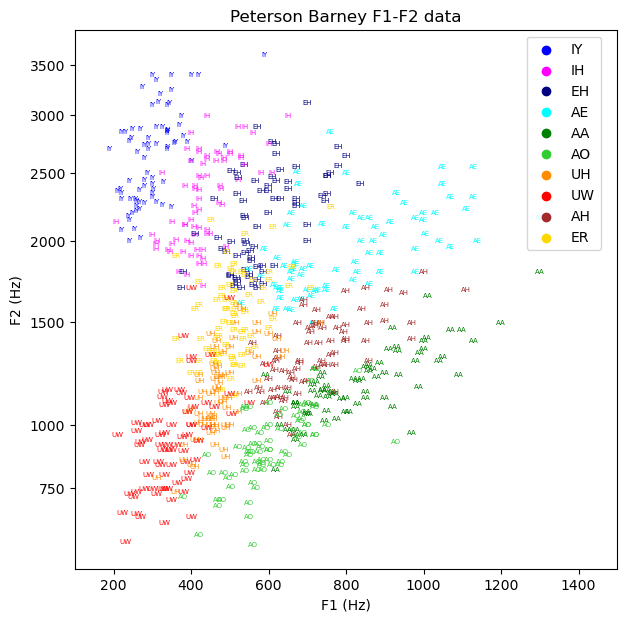

In [8]:
marker_size = 20
PLT_TEXT = True
#
fig1,ax = plt.subplots(figsize=(7,7))
if PLT_TEXT: marker_size = 0
sns.scatterplot(ax=ax,x='F1',y='F2t',data=data,hue="vowel",marker='D',s=marker_size,hue_order=vowels)
if PLT_TEXT:
    for i,entry in data.iterrows():
        vow = entry['vowel']
        ax.text(entry['F1'],entry['F2t'],vow,ha='center',va='center',fontsize=5,color=vowel2color[vow] )
ax.set_yticks(yticks_l,ytick_labels)
ax.set_xlim(xlim)
ax.legend(loc='upper left', bbox_to_anchor=(0.82,1));
ax.set_xlabel('F1 (Hz)')
ax.set_ylabel('F2 (Hz)')
ax.set_title('Peterson Barney F1-F2 data');

### Gaussian Modeling and Confidence Ellipses
Gaussian modeling is a standard and intuitive approach for scatter data as observed in the Peterson Barney data.   
We show the data with a number of confidence ellipses; values selected are 1.0, 1.5 and 2.0.
The Gaussian model may not be perfect, but it does a more than decent job.
The 2*sigma contours are a sensible approximation of the region wherein Formants of a specific vowel are expected to appear.   
Small variants are made of this plot: just the confidence ellipses, the mean values added to them and the mean values per gender added to the plots.  The latter shows considerable variation between male and female values (due to vocal tract length differences) and it also draws our attention to the underlying bimodal distribution of the data.

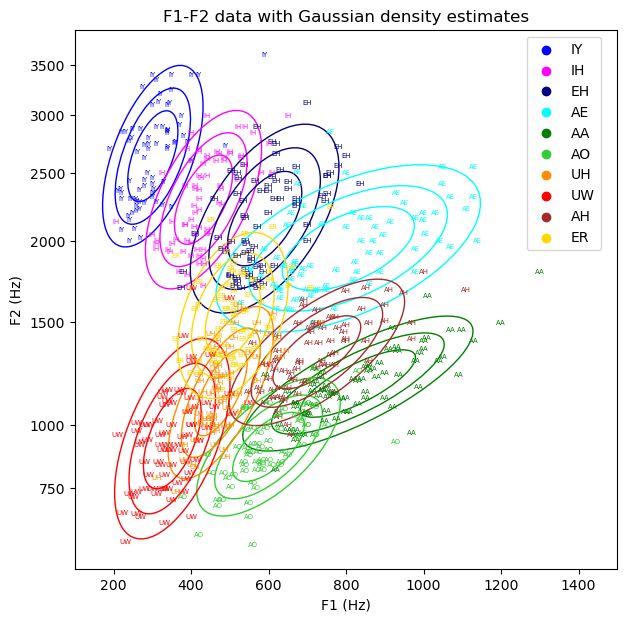

In [9]:
# add confidence ellipses to previous plots
fig2 = deepcopy(fig1)
ax = fig2.get_axes()[0]
xfeat = 'F1'
yfeat = 'F2t'
sigmas = [1, 1.5, 2.0]
for vow in vowels:
    vowdata = data.loc[ data['vowel'].isin([vow]) ]  
    for sig in sigmas:
        Spch.plot_confidence_ellipse(vowdata[xfeat], vowdata[yfeat], ax, n_std=sig, edgecolor=vowel2color[vow] )
ax.set_title('F1-F2 data with Gaussian density estimates');
#
display(fig2)

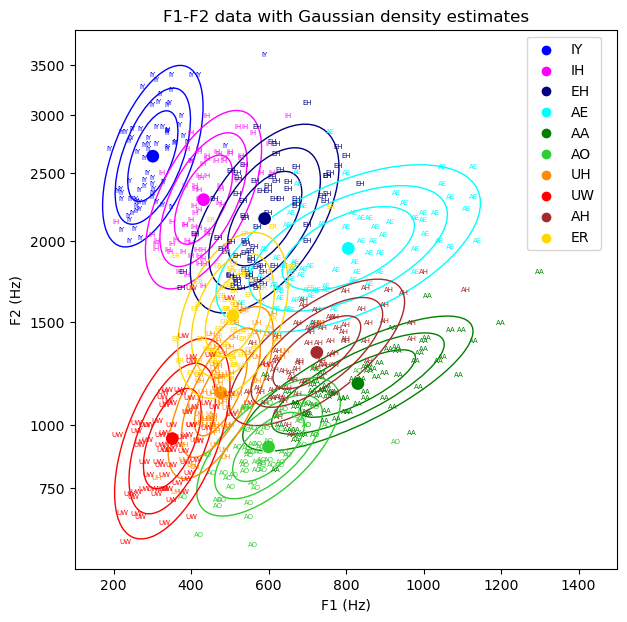

In [10]:
# add average formant values to the plot
fig3 = deepcopy(fig2)
ax = fig3.get_axes()[0]
sns.scatterplot(data=formants_all,ax=ax,x='F1',y=formants_all['F2t'],
                hue='vowel',hue_order=vowels,s=100,legend=False)  
fig3

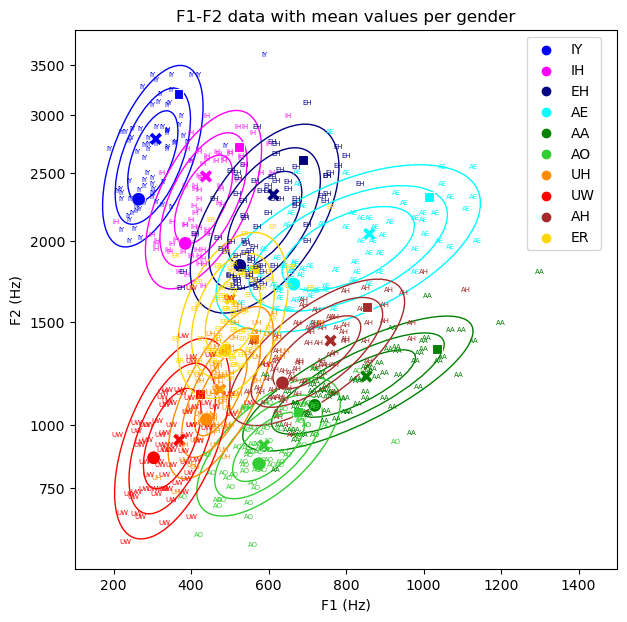

In [11]:
# add average formant values BY GENDER to the plot
fig3b = deepcopy(fig2)
ax = fig3b.get_axes()[0]
sns.scatterplot(data=formants_gd.stack(),ax=ax,x='F1',y='F2t', 
                hue='vowel',hue_order=vowels,style="gender",s=100,legend=False)  
ax.set_title('F1-F2 data with mean values per gender');
fig3b

### Kernel Density Estimates
It is clear that our Gaussian Density estimates of the Formant distributions
don't match well with the per formant 'regions' drawn in the paper
We may assume that these were drawn by hand and inspired by a motivation to come up
with maximally non overlapping F1-F2 regions
Here we use Kernel Density plots that are more suitable to model data that is not Gaussian.   
We played a bit with the control parameters and this is the best we could come up with.
For some regions, like 'IY' and 'IH' the results are quite good.  However the same parameters
don't seem to work well for e.g. the 'AE' region .  Also the overlap of the 'UW' vs 'UH' and 'AA' vs 'AO' is significantly larger than in the PB plots, which hints as a bias in the human interpretation of the results in the PB paper.

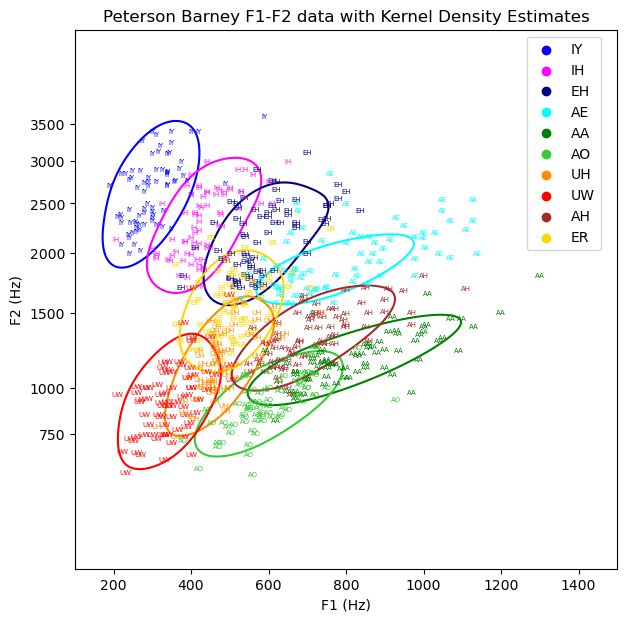

In [12]:
#
fig4 = deepcopy(fig1)
ax = fig4.axes[0]
sns.kdeplot(data, x="F1", y="F2t",hue="vowel", ax=ax, hue_order=vowels,levels=[ 0.35 ],bw_adjust=1.8,legend=None)
ax.set_title('Peterson Barney F1-F2 data with Kernel Density Estimates');
fig4

In [21]:
# convert the full notebook
! jupyter nbconvert PetersonBarney.ipynb --to html

[NbConvertApp] Converting notebook PetersonBarney.ipynb to html
[NbConvertApp] WARNING | Alternative text is missing on 5 image(s).
[NbConvertApp] Writing 1150873 bytes to PetersonBarney.html


In [13]:
# save selected figures
#fig1.savefig("../figures/pb_fig1.png")
#fig2.savefig("../figures/pb_fig2.png")
#fig3.savefig("../figures/pb_fig3.png")
#fig3b.savefig("../figures/pb_fig3b.png")
#fig4.savefig("../figures/pb_fig4.png")